# Homework 11 - Time seriece clustering exercise
Author: Unisse Chua (uc288)

In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd
import geopandas as gpd

import os
import sys
import zipfile 

import matplotlib.pylab as pl
%pylab inline

from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist, pdist
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.mixture import GMM

from scipy.spatial.distance import cdist, pdist

Populating the interactive namespace from numpy and matplotlib


In [2]:
PUIdata = os.getenv('PUIDATA')
print(PUIdata)

/home/cusp/uc288/PUIdata


# Data

Download the census bureau business data for all years 1993-2014. You can investigate using the API (I have not done it with the census bureau). I did is as you see below

### Uncomment when running for the first time

In [3]:
# !for ((y=94; y<=99; y+=1)); do wget \
# https://www2.census.gov/Econ2001_And_Earlier/CBP_CSV//zbp$y\totals.zip; done

# !for ((y=0; y<=1; y+=1)); do wget \
# https://www2.census.gov/Econ2001_And_Earlier/CBP_CSV//zbp0$y\totals.zip; done

# !for ((y=2; y<=9; y+=1)); do wget \
# https://www2.census.gov/econ200$y\/CBP_CSV/zbp0$y\totals.zip; done

# !for ((y=10; y<=14; y+=1)); do wget \
# https://www2.census.gov/econ20$y\/CBP_CSV/zbp$y\totals.zip; done

In [4]:
!ls

HW11_Assignment1.ipynb	HW11_Assignment2.ipynb	README.md


In [5]:
# for i in range(94,100):
#     os.system('mv zbp' + str(i) + 'totals.zip ' + PUIdata)

In [6]:
# for i in range(0,15):
#     os.system('mv zbp' + str(i).zfill(2) + 'totals.zip ' + PUIdata)

 Download the NYC zipcodes shapefile. One of many ways in which you can get the zipcodes shapefile for NYC
 https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip


## NYC ZIP Codes Shapefile

In [7]:
if not os.path.isdir(PUIdata + '/ZIP_CODES'):
    print('Download and unzip file...')
    os.system('wget https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip')
    os.system('mv application%2Fzip ' + PUIdata)
    os.system('unzip ' + PUIdata + '/application%2Fzip -d ' + PUIdata + '/ZIP_CODES')

if os.path.isdir(PUIdata + '/ZIP_CODES'):
    for file in os.listdir(PUIdata + '/ZIP_CODES'):
        if file.endswith('.shp'):
            print('Shapefile in place..')
            shpfile = file

Shapefile in place..


In [8]:
shpfile

'ZIP_CODE_040114.shp'

In [9]:
zipdf = gpd.GeoDataFrame.from_file(PUIdata + '/ZIP_CODES/' + shpfile)
zipdf.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.251871482 188138.3800067157,..."
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.712964058 186926.4395172149,..."
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.275535807 183696.33770971, 1..."
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.3654508889 183617.6128015518,..."
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.1134308875 176307.4958601296,..."


In [10]:
zipdf = zipdf[['ZIPCODE', 'geometry']]
zipdf['ZIPCODE'] = pd.to_numeric(zipdf['ZIPCODE'])
zipdf.head()

,ZIPCODE,geometry
0,11436,"POLYGON ((1038098.251871482 188138.3800067157,..."
1,11213,"POLYGON ((1001613.712964058 186926.4395172149,..."
2,11212,"POLYGON ((1011174.275535807 183696.33770971, 1..."
3,11225,"POLYGON ((995908.3654508889 183617.6128015518,..."
4,11218,"POLYGON ((991997.1134308875 176307.4958601296,..."


## You can use zipfile module in python to unzip the files
it should be install in your system, but if it is not you can get the code with wget from here
https://github.com/python/cpython/blob/2.7/Lib/zipfile.py
remembering to use the raw link
(or you can use the usual shell commands, and miss the chance to learn something new)

In [11]:
ts_df = pd.DataFrame()

In [12]:
for i in range(94,100):
    fname='zbp' + str(i) + 'totals.zip'
    time = 1900 + i
    zf = zipfile.ZipFile(PUIdata + '/' + fname)
    df = pd.read_csv(zf.open(fname.replace('.zip','.txt'))).assign(year=time)
    df.columns = [x.upper() for x in df.columns]
    df = df[['ZIP', 'EST', 'YEAR']]
    ts_df = ts_df.append(df)

In [13]:
for i in range(0,15):
    fname='zbp' + str(i).zfill(2) + 'totals.zip'
    time = 2000 + i
    zf = zipfile.ZipFile(PUIdata + '/' + fname)
    df = pd.read_csv(zf.open(fname.replace('.zip','.txt'))).assign(year=time)
    df.columns = [x.upper() for x in df.columns]
    df = df[['ZIP', 'EST', 'YEAR']]
    ts_df = ts_df.append(df)

In [14]:
ts_df.shape

(828791, 3)

# Data cleaning

you may need to clean your data: for some NYC zip codes there may be no info
sanity check: you should have 20 (N_timestamps) datapoints per time series and about 250 zipcodes (Nzipcodes)


IMPORTANT: we talked about the importance of "whitening" your data.
Whitenings decorrelates the data: it makes the features independent so that the data covariance matrix is the identity matrix.
Whitening your data in time series analysis is in most cases **wrong**: you are modifying your time behaviour. This is because of the strong correlation between features (two consecutive time stamps for the same observation, the same zip code here, are strongly correlated). Here instead you want to standardize your time series: subtract the mean and divide each time series (separately) by its standard deviation. As a sanity check (if you use skitlearn Kmeans or skitlearns kmeans2): you want your data array to be shaped Nzipcodes x Ntimestamps

mydata.shape should be (Nzipcodes, Ntimestamps)

mydata[i].std() shoould be 1 for all i in range(len(Nzipcodes))

mydata[i].mean() should be ~0 for all i in range(len(Nzipcodes))



## TASKS:
    
    1. get and prep your data.
    2. cluster the NUMBER OF ESTABLISHMENTS time series with K-means in **a few** clusters (as discussed there is no real good, sound way to decide what a good number is here. try a few options, keeping in mind a few is more than a couple, but i recommand you stay within the single digit numbers)
    3. plot the cluster centers (if you used K means those are the means of the clusters). you can plot for example the cluster centers overlayed on each time series (using the alpha channel to control the opacity in the plot may be helpful here).
    4. Use another clustering algorithm (of your choice)
    5. overlay your data on a NYC map: you can use shapefiles for the zip codes and different colors for different clusters
    6. Compare the results of the 2 algorithms
    7. attempt an interpretation. this is dangerous ground: clustering is an exploratory tool so you do not want to jump to conclusions because you see some clusters! but seeing structure in your data can inform your next moves as an investigator. 
    

In [15]:
ts_df.head()

,ZIP,EST,YEAR
0,1001,439,1994
1,1002,450,1994
2,1003,10,1994
3,1004,47,1994
4,1005,92,1994


In [16]:
ts_df = pd.pivot_table(ts_df, values='EST', index='ZIP', columns='YEAR')
ts_df.head()

YEAR,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
ZIP,,,,,,,,,,,,,,,,,,,,,
501,NaN,2.0,4.0,4.0,3.0,2.0,1.0,6.0,11.0,7.0,...,2.0,8.0,5.0,3.0,2.0,2.0,2.0,2.0,2.0,4.0
1000,NaN,4.0,11.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1001,439.0,439.0,433.0,457.0,444.0,469.0,493.0,490.0,490.0,505.0,...,509.0,509.0,503.0,477.0,458.0,448.0,436.0,453.0,439.0,458.0
1002,450.0,467.0,487.0,500.0,490.0,558.0,563.0,587.0,566.0,586.0,...,589.0,582.0,596.0,584.0,571.0,570.0,558.0,572.0,572.0,560.0
1003,10.0,10.0,13.0,15.0,14.0,13.0,13.0,13.0,15.0,16.0,...,12.0,12.0,16.0,17.0,16.0,16.0,16.0,15.0,15.0,18.0


In [17]:
ts_df.shape

(42671, 21)

In [18]:
ts_df.dropna(axis=0, inplace=True)

In [19]:
ts_df = zipdf.merge(ts_df, right_index=True, left_on='ZIPCODE')

In [20]:
ts_df.drop('geometry', axis=1, inplace=True)
ts_df.set_index('ZIPCODE', inplace=True)
ts_df.head()

,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
ZIPCODE,,,,,,,,,,,,,,,,,,,,,
11436,51.0,50.0,53.0,51.0,51.0,58.0,65.0,57.0,78.0,74.0,...,82.0,80.0,84.0,90.0,92.0,98.0,101.0,95.0,99.0,109.0
11213,406.0,420.0,433.0,456.0,476.0,473.0,477.0,493.0,546.0,569.0,...,556.0,565.0,556.0,592.0,621.0,675.0,674.0,726.0,755.0,772.0
11212,505.0,494.0,502.0,527.0,519.0,541.0,520.0,527.0,577.0,581.0,...,587.0,570.0,587.0,602.0,647.0,699.0,713.0,721.0,731.0,752.0
11225,381.0,387.0,388.0,410.0,416.0,409.0,417.0,422.0,479.0,488.0,...,491.0,499.0,514.0,520.0,543.0,580.0,597.0,623.0,673.0,696.0
11218,985.0,1015.0,1049.0,1075.0,1118.0,1149.0,1161.0,1180.0,1228.0,1247.0,...,1332.0,1331.0,1377.0,1397.0,1457.0,1474.0,1523.0,1605.0,1687.0,1736.0


In [21]:
ts_df.shape

(243, 21)

## REMINDER
mydata.shape should be (Nzipcodes, Ntimestamps)

mydata[i].std() shoould be 1 for all i in range(len(Nzipcodes))

mydata[i].mean() should be ~0 for all i in range(len(Nzipcodes))

In [22]:
std_ts = ((ts_df.T - ts_df.mean(axis=1)) / ts_df.std(axis=1)).T

In [23]:
std_ts.shape

(243, 21)

*Sanity check on the standardization*.
Checking the mean and standard deviation of the first 10 rows.

In [24]:
for j in range(0,10):
    ts = std_ts.iloc[j]
    print("STD for ZIP {} is {:.2f}".format(ts.name, ts.std()))
    print("MEAN for ZIP {} is {:.2f}".format(ts.name, ts.mean()))  

STD for ZIP 11436 is 1.00
MEAN for ZIP 11436 is -0.00
STD for ZIP 11213 is 1.00
MEAN for ZIP 11213 is -0.00
STD for ZIP 11212 is 1.00
MEAN for ZIP 11212 is 0.00
STD for ZIP 11225 is 1.00
MEAN for ZIP 11225 is -0.00
STD for ZIP 11218 is 1.00
MEAN for ZIP 11218 is -0.00
STD for ZIP 11226 is 1.00
MEAN for ZIP 11226 is 0.00
STD for ZIP 11219 is 1.00
MEAN for ZIP 11219 is -0.00
STD for ZIP 11210 is 1.00
MEAN for ZIP 11210 is -0.00
STD for ZIP 11230 is 1.00
MEAN for ZIP 11230 is 0.00
STD for ZIP 11204 is 1.00
MEAN for ZIP 11204 is 0.00


## Clustering

In [25]:
# CODE FROM ADS LAB

def elbow(data,K):
#data is your input as numpy form
#K is a list of number of clusters you would like to show.
    # Run the KMeans model and save all the results for each number of clusters
    KM = [KMeans(n_clusters=k, random_state=123).fit(data) for k in K]
    
    # Save the centroids for each model with a increasing k
    centroids = [k.cluster_centers_ for k in KM]

    # For each k, get the distance between the data with each center. 
    D_k = [cdist(data, cent, 'euclidean') for cent in centroids]
    
    # But we only need the distance to the nearest centroid since we only calculate dist(x,ci) for its own cluster.
    globals()['dist'] = [np.min(D,axis=1) for D in D_k]
    
    # Calculate the Average SSE.
    avgWithinSS = [sum(d)/data.shape[0] for d in dist]
    
    
    # elbow curve
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, avgWithinSS, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average within-cluster sum of squares')
    plt.title('Elbow for KMeans clustering')
    plt.show()
    
    
    # Total with-in sum of square plot. Another way to show the result.
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(data)**2)/data.shape[0]
    bss = tss-wcss
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, bss/tss*100, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Percentage of variance explained')
    plt.title('Elbow for KMeans clustering')
    plt.show()

For n_clusters = 2 The average silhouette_score is : 0.572142801777
For n_clusters = 3 The average silhouette_score is : 0.541072613328
For n_clusters = 4 The average silhouette_score is : 0.501207133658
For n_clusters = 5 The average silhouette_score is : 0.331797446821
For n_clusters = 6 The average silhouette_score is : 0.32721517486
For n_clusters = 7 The average silhouette_score is : 0.251977848353
For n_clusters = 8 The average silhouette_score is : 0.241967649096
For n_clusters = 9 The average silhouette_score is : 0.158254524982
For n_clusters = 10 The average silhouette_score is : 0.150430762634


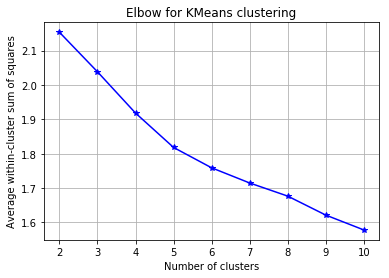

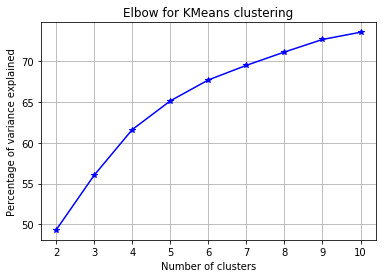

In [26]:
# CODE FROM ADS LAB

range_n_clusters = range(2,11)
for n_clusters in range_n_clusters:

    clusterer = KMeans(n_clusters=n_clusters, random_state=123)
    cluster_labels = clusterer.fit_predict(std_ts)
    silhouette_avg = silhouette_score(std_ts, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    sample_silhouette_values = silhouette_samples(std_ts, cluster_labels)
elbow(std_ts,range_n_clusters)

## Figure 1. Elbow for K-means clustering of the number of businesses per ZIP Code
The elbow for the K-means clustering where k is from 2 to 10 does not show a prominent sharp curve but we can see that the change gets smaller after k=5 so for this assignment, I'll be using 5 clusters.

In [27]:
n = 5
km = KMeans(n_clusters=n, random_state=123)
km_res = km.fit(std_ts)

In [28]:
n = 5
agc = AgglomerativeClustering(n_clusters=n,  compute_full_tree=True)
agc_res = agc.fit(std_ts)

In [29]:
std_ts['KLABEL'] = km_res.labels_
std_ts['AGCLABEL'] = agc_res.labels_

K-means provides the cluster centers for the results. Converting the values into a Pandas DataFrame for easier plotting of the time series and the centers.

In [30]:
centersKM = pd.DataFrame(km_res.cluster_centers_)
centersKM.columns = std_ts.columns[:-2]
centersKM.head()

,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
0,-1.329773,-1.253106,-1.154477,-1.006409,-0.905354,-0.871665,-0.747412,-0.650730,-0.285028,-0.143496,...,0.145892,0.189600,0.376000,0.499544,0.625136,0.876965,1.042539,1.278769,1.537003,1.750877
1,1.228315,0.744933,0.240404,-0.150314,-0.341420,0.036786,-0.258669,-0.411081,-0.824537,-0.953571,...,-0.417455,-0.436914,-0.162135,-0.198708,-0.056953,0.027780,0.166045,0.665710,0.717353,0.976713
2,0.401754,0.787467,0.795534,0.916083,0.988224,1.073947,1.103965,0.806024,0.100024,-0.000380,...,-0.069741,-0.028230,-0.400295,-0.508005,-0.572985,-0.803573,-0.989506,-1.197391,-1.221030,-1.189183
3,-2.029084,-1.636149,-1.291084,-0.862477,-0.703242,-0.354384,-0.214182,-0.254893,-0.026652,0.179079,...,0.611161,0.710390,0.759014,0.717206,0.630620,0.612192,0.653549,0.489714,0.622532,0.859549
4,-0.915372,-0.845064,-0.435149,-0.097905,0.106997,0.012602,0.583817,0.757792,0.760461,0.783043,...,0.618622,0.269061,0.052397,-0.312037,-0.617808,-0.678624,-0.980044,-0.341778,-0.040526,0.035944


In [31]:
geo_cluster = zipdf.merge(std_ts[['KLABEL', 'AGCLABEL']], left_on='ZIPCODE', right_index=True)

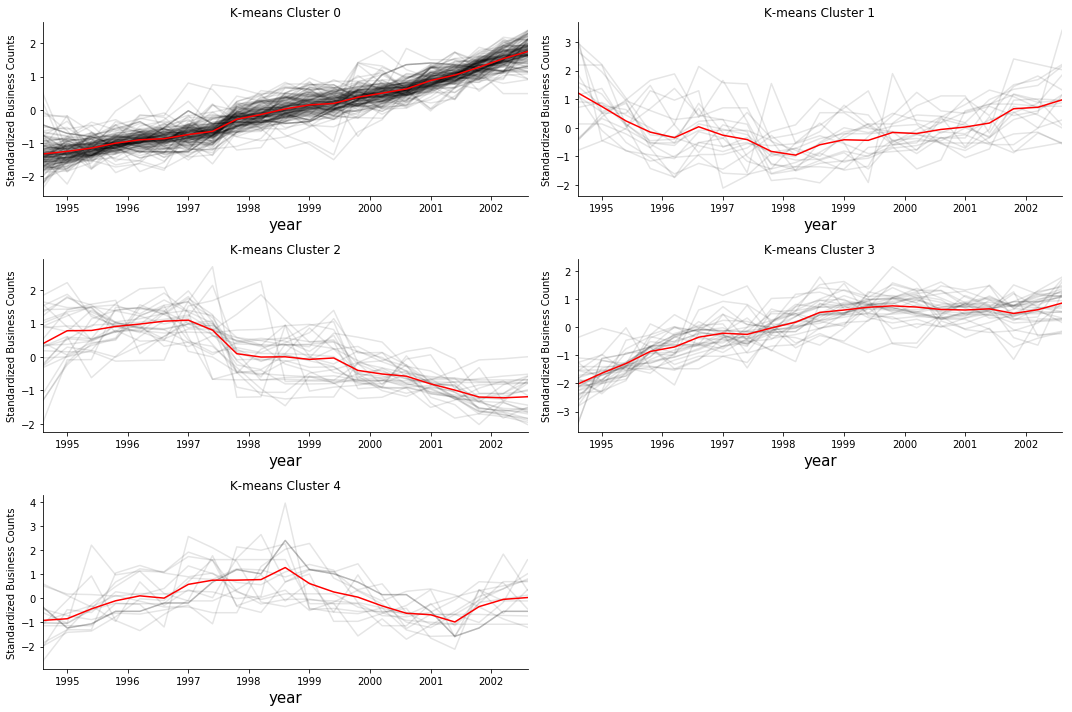

In [32]:
fig = pl.figure(figsize=(15,10))

for k in range(n):
    ax = fig.add_subplot(3,2,k+1)
    cluster = std_ts[std_ts['KLABEL'] == k]
    ax.plot(cluster.iloc[:,:-2].T, c='k', alpha=0.1)
    ax.plot(centersKM.iloc[k], c='r')
    ax.set_xticklabels(cluster.columns[:-2])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel('year', fontsize=15)
    ax.set_ylabel('Standardized Business Counts', fontsize=10)
    ax.set_xlim([1994,2014])
    ax.set_title("K-means Cluster {}".format(str(k)))
    
pl.tight_layout()

## Figure 2. K-Means Clustering of the Business Trend per ZIP Code in NYC
The gray lines show the standardized number of businesses per ZIP Code while the red line is the center (mean) of all the time series in the cluster. We can see that there is a big group of ZIP codes in cluster 0. For cluster 2, we can see that they show a downward trend.

In [33]:
agc_centers = pd.DataFrame()

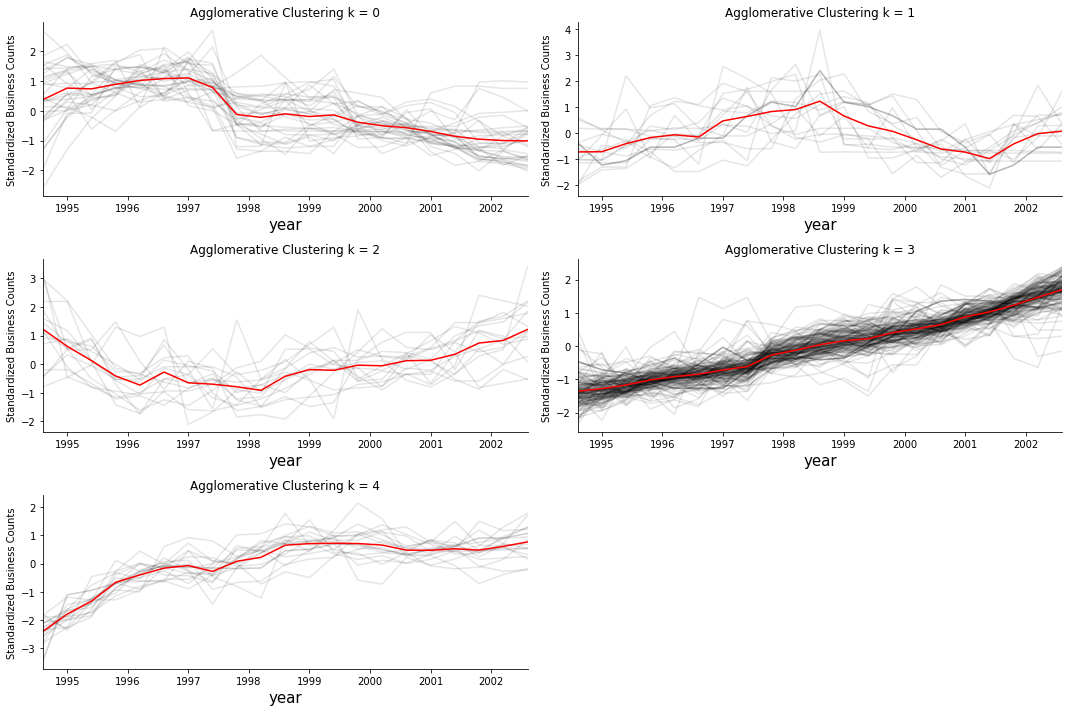

In [34]:
fig = pl.figure(figsize=(15,10))

for k in range(n):
    ax = fig.add_subplot(3,2,k+1)
    cluster = std_ts[std_ts['AGCLABEL'] == k]
    ax.plot(cluster.iloc[:,:-2].T, c='k', alpha=0.1)
    agc_centers = agc_centers.append(cluster.iloc[:,:-2].mean(),ignore_index=True)
    ax.plot(cluster.iloc[:,:-2].mean(), c='r')
    ax.set_xticklabels(cluster.columns[:-2])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel('year', fontsize=15)
    ax.set_ylabel('Standardized Business Counts', fontsize=10)
    ax.set_xlim([1994,2014])
    ax.set_title("Agglomerative Clustering k = {}".format(str(k)))
    
pl.tight_layout()

## Figure 3. Agglomerative Clustering of the Business Trend per ZIP Code in NYC
Similar to Figure 2, only this uses Agglomerative Clustering instead of K-means clustering. Here we can see that the clusters look similar to the K-means clustering.


This table shows the mapping of the K-means cluster to the Agglomerative clusters.

| K Means Cluster | Agglomerative Cluster |
| --------------- | --------------------- |
|  0              |          3            |
|  1              |          2            |
|  2              |          0            |
|  3              |          4            |
|  4              |          1            |

In [35]:
agc_centers.head()

,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
0,0.375351,0.762755,0.736535,0.890028,1.019741,1.081348,1.104287,0.782074,-0.124248,-0.221498,...,-0.193206,-0.137930,-0.384032,-0.502805,-0.566787,-0.694868,-0.856635,-0.954452,-0.999948,-1.012417
1,-0.719188,-0.711710,-0.400728,-0.169742,-0.059524,-0.144779,0.476144,0.645124,0.835279,0.911482,...,0.665260,0.282476,0.075125,-0.253356,-0.608228,-0.727297,-0.977740,-0.413188,-0.015574,0.076448
2,1.222823,0.625098,0.126723,-0.410517,-0.728822,-0.273983,-0.647794,-0.697427,-0.786204,-0.911704,...,-0.186600,-0.213269,-0.033127,-0.054216,0.123486,0.137257,0.345760,0.740434,0.830372,1.214154
3,-1.356652,-1.280391,-1.168695,-1.017336,-0.917790,-0.844562,-0.718429,-0.613851,-0.270899,-0.121914,...,0.161353,0.222095,0.405476,0.519907,0.648064,0.880712,1.029541,1.230234,1.472022,1.697908
4,-2.408928,-1.793865,-1.338765,-0.665638,-0.402575,-0.159936,-0.068427,-0.276676,0.082869,0.224138,...,0.712014,0.723522,0.714169,0.658969,0.479755,0.473111,0.526670,0.481544,0.612338,0.771575


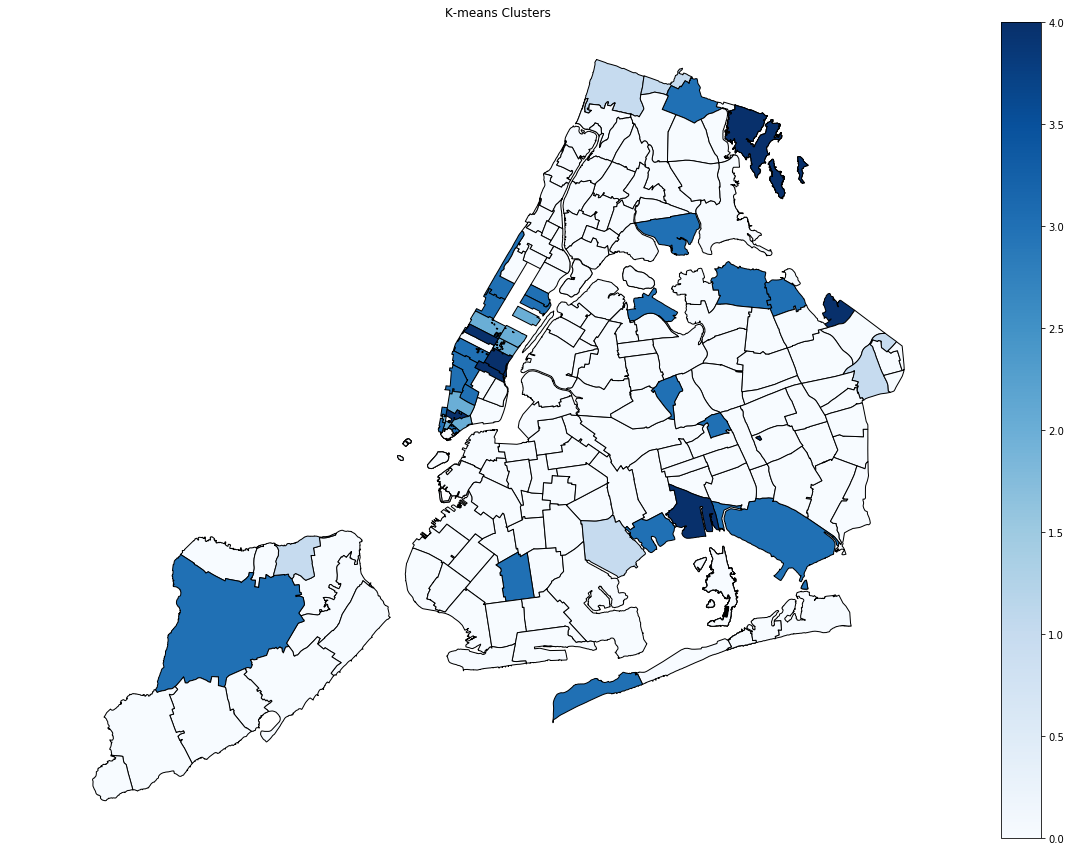

In [36]:
fig2 = pl.figure(figsize=(20,15))
ax2 = fig2.add_subplot(111)

geo_cluster.plot(ax=ax2, column='KLABEL', cmap='Blues', edgecolor='k', lw=1, legend=True)
ax2.set_title('K-means Clusters')
ax2.axis('off');

## Figure 4. Geographic Representation of K-means Clustering of Business Trends (n = 5)
Each color signifies one cluster and as seen from the time series clusters in Figure 2, a lot of areas are clustered together. We can see that areas in the Midtown and Downtown Manhattan have a number of ZIP code areas next to each other clustered in the same group.

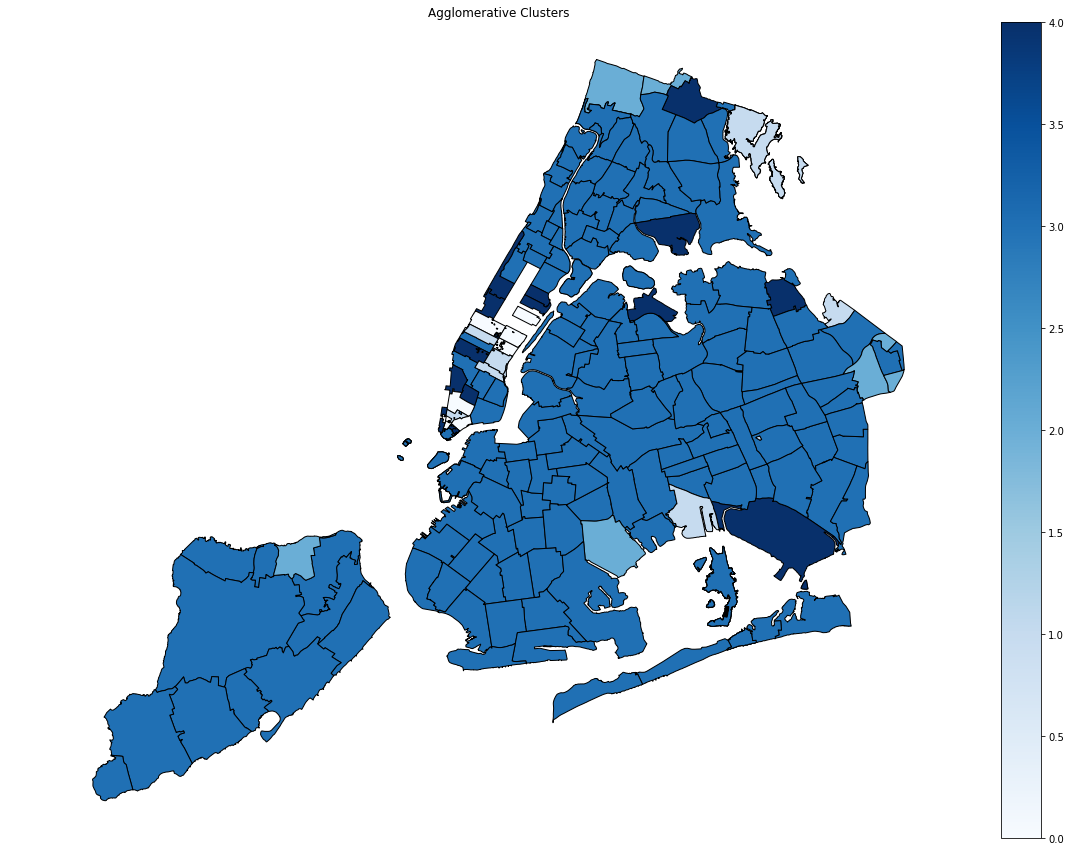

In [37]:
fig2 = pl.figure(figsize=(20,15))
ax2 = fig2.add_subplot(111)

geo_cluster.plot(ax=ax2, column='AGCLABEL', cmap='Blues', edgecolor='k', lw=1, legend=True)
ax2.set_title('Agglomerative Clusters')
ax2.axis('off');

## Figure 5. Geographic Representation of Agglomerative Clustering of Business Trends (n = 5)
Similar to Figure 4, each color signifies one cluster. Here we can see the differences of the K-means and Agglomerative clustering better. In the K-means clustering, we saw there were 2 ZIP code areas in Staten Island which are in different clusters, but here we only see one ZIP code in Staten Island in a different cluster as the rest of the borough.

Mapping the Midtown and Downtown Manhattan areas, there clustering of that area looks similar as well.

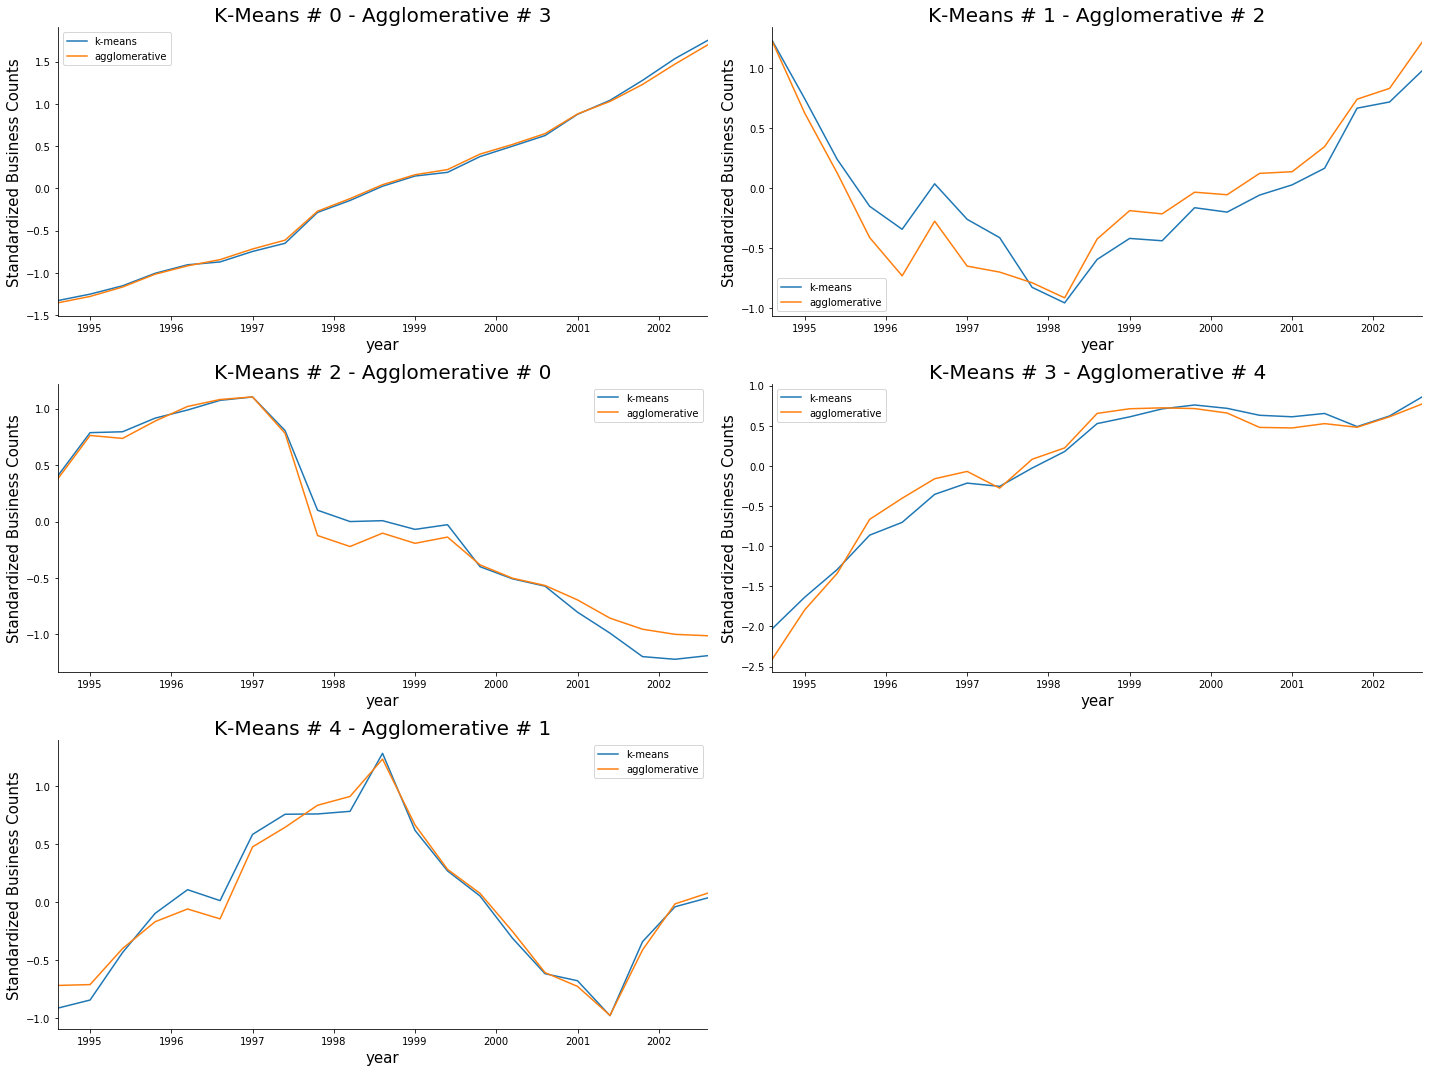

In [38]:
fig = pl.figure(figsize=(20,15))

cl_order = [3, 2, 0, 4, 1]

for i in range(len(centersKM)):
    ax = fig.add_subplot(3,2,i+1)
    ax.plot(centersKM.iloc[i], label='k-means')
    ax.plot(agc_centers.iloc[cl_order[i]], label='agglomerative')
    ax.set_xticklabels(centersKM.columns)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel('year', fontsize=15)
    ax.set_ylabel('Standardized Business Counts', fontsize=15)
    ax.set_xlim([1994,2014])
    ax.set_title("K-Means # {} - Agglomerative # {}".format(i, cl_order[i]), fontsize=20)
    ax.legend()

pl.tight_layout()

## Figure 6. Overlay of Cluster Centers for K-means and Agglomerative Clustering
Here we can see the overlap of the cluster centers of the k-means in blue and the cluster centers of agglomerative clustering in orange. We see that both clustering techniques were able to capture similar trends with some differences.